#Assignment 2
#RFM Analysis
#20233219 Taewoo Kim

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
pd.set_option('mode.chained_assignment',  None) # <==== 경고를 끈다

In [2]:
df = pd.read_csv('online_retail_II.csv')

In [3]:
#불필요한 column 제거
df.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
#Revenue 변수 생성
df['Revenue'] = df['Quantity']*df['Price']

In [5]:
#'Customer ID' 결측치는 새로운 데이터프레임에 저장, 기존 데이터프레임에서는 삭제
df_noID = df[df['Customer ID'].isna()]
df.dropna(subset=['Customer ID'], inplace = True)
#'Description' 결측치는 채워줌
df['Description'].fillna('No Description', inplace = True)
#음수 제거
df = df[df.Quantity > 0]
df = df[df.Price >= 0]

In [6]:
#주문취소에 대한 처리
filter = df['Invoice'].str.contains('C')
#새로운 데이터프레임에 주문취소 정보 저장
df_cancel = df[filter]
#기존 데이터프레임에서 주문취소 정보 삭제 후 cl_df로 저장
cl_df = df[~df['Invoice'].str.contains('C')]

In [7]:
#데이터타입 변환
cl_df['Invoice'] = cl_df['Invoice'].astype('category')
cl_df['StockCode'] = cl_df['StockCode'].astype('category')
cl_df['Description'] = cl_df['Description'].astype('category')
cl_df['Customer ID'] = cl_df['Customer ID'].astype('object')
cl_df['InvoiceDate'] = pd.to_datetime(cl_df['InvoiceDate'])
cl_df['Country'] = cl_df['Country'].astype('category')

In [8]:
#날짜 출력 format 변경
cl_df['InvoiceDate'] = cl_df['InvoiceDate'].dt.strftime("%Y-%m-%d")
cl_df['InvoiceDate'] = pd.to_datetime(cl_df['InvoiceDate'])

In [9]:
cl_df['Quantity'] = cl_df['Quantity'].astype('int32')
cl_df['Price'] = cl_df['Price'].astype('int32')
cl_df['Revenue'] = cl_df['Revenue'].astype('float32')

In [10]:
print(cl_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805620 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805620 non-null  category      
 1   StockCode    805620 non-null  category      
 2   Description  805620 non-null  category      
 3   Quantity     805620 non-null  int32         
 4   InvoiceDate  805620 non-null  datetime64[ns]
 5   Price        805620 non-null  int32         
 6   Customer ID  805620 non-null  object        
 7   Country      805620 non-null  category      
 8   Revenue      805620 non-null  float32       
dtypes: category(4), datetime64[ns](1), float32(1), int32(2), object(1)
memory usage: 36.2+ MB
None


In [37]:
# R 계산
latest_date = cl_df['InvoiceDate'].max()
cl_df['Recency'] = (latest_date - cl_df['InvoiceDate']).dt.days

# F 계산
cl_df_frequency = cl_df.groupby('Customer ID', as_index=False)['Invoice'].count()
cl_df_frequency.columns = ['Customer ID', 'Frequency']
# M 계산
cl_df_monetary = cl_df.groupby('Customer ID', as_index=False)['Revenue'].sum()
cl_df_monetary.columns = ['Customer ID', 'Monetary']

# RFM 데이터프레임 생성
rfm = cl_df_frequency.merge(cl_df_monetary, on='Customer ID').merge(cl_df[['Customer ID', 'Recency']], on='Customer ID')
rfm = rfm.reindex(columns=['Customer ID', 'Recency', 'Frequency', 'Monetary'])

# RFM 각각 3등급으로 나누기
rfm['R_rank'] = pd.qcut(rfm['Recency'], q=3, labels=['3', '2', '1']) # recency의 수치가 낮을수록 높은 집단
rfm['F_rank'] = pd.qcut(rfm['Frequency'], q=3, labels=['1', '2', '3']) 
rfm['M_rank'] = pd.qcut(rfm['Monetary'], q=3, labels=['1', '2', '3']) 

# R, F, M 값을 이용해 27개 그룹 생성
rfm['RFM_Group'] = rfm['R_rank'].astype(int)*100 + rfm['F_rank'].astype(int)*10 + rfm['M_rank'].astype(int)
rfm['R_rank'] = rfm['R_rank'].astype(int)
rfm['F_rank'] = rfm['F_rank'].astype(int)
rfm['M_rank'] = rfm['M_rank'].astype(int)

# customer ID 기준으로 중복 값 제거
rfm.drop_duplicates(subset=['Customer ID'], inplace=True)

# 중복된 'customerID' 값을 제거하고 'country' 값만 선택한 임의의 데이터프레임 생성
country_df = cl_df.drop_duplicates(subset='Customer ID')[['Customer ID', 'Country']]
# 두 데이터프레임을 'customerID'를 기준으로 합침.
rfm = pd.merge(rfm, country_df, on='Customer ID')

In [38]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5881 entries, 0 to 5880
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Customer ID  5881 non-null   object  
 1   Recency      5881 non-null   int64   
 2   Frequency    5881 non-null   int64   
 3   Monetary     5881 non-null   float32 
 4   R_rank       5881 non-null   int32   
 5   F_rank       5881 non-null   int32   
 6   M_rank       5881 non-null   int32   
 7   RFM_Group    5881 non-null   int32   
 8   Country      5881 non-null   category
dtypes: category(1), float32(1), int32(4), int64(2), object(1)
memory usage: 305.8+ KB


In [40]:
# Summarize each group's feature
group_summary = rfm.groupby('RFM_Group').agg({
    'Customer ID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
})

In [41]:
print(group_summary)

           Customer ID     Recency    Frequency      Monetary
RFM_Group                                                    
111               2141  615.834190    52.776273    839.882812
112                377  647.018568   128.297082   3798.537842
113                 53  681.773585    98.849057  18843.552734
121                147  639.183673   307.802721   1675.212769
122                386  668.994819   320.398964   4905.337402
123                143  691.797203   391.839161  17273.830078
132                 68  676.323529   799.191176   5601.703613
133                136  701.705882  1414.639706  39717.640625
211               1230  354.300813    44.361789    671.827454
212                 74  351.824324   121.756757   3488.826904
213                 11  362.000000    76.090909  16802.789062
221                 42  360.928571   298.761905   1484.197632
222                 52  367.038462   305.057692   4658.142578
223                  8  380.375000   453.375000  43770.101562
231     

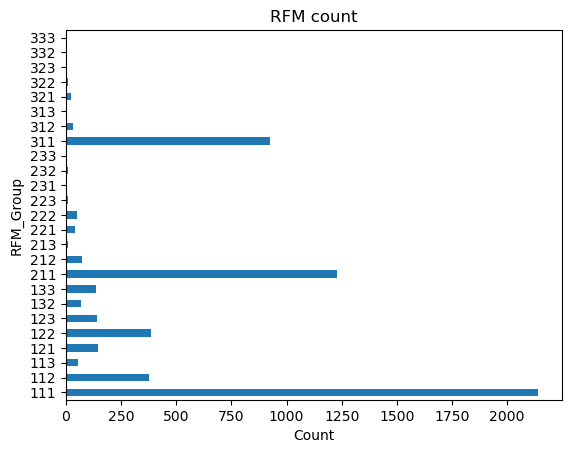

In [42]:
#count
count = group_summary['Customer ID']
count.plot.barh()
plt.title('RFM count')
plt.xlabel('Count')
plt.show()

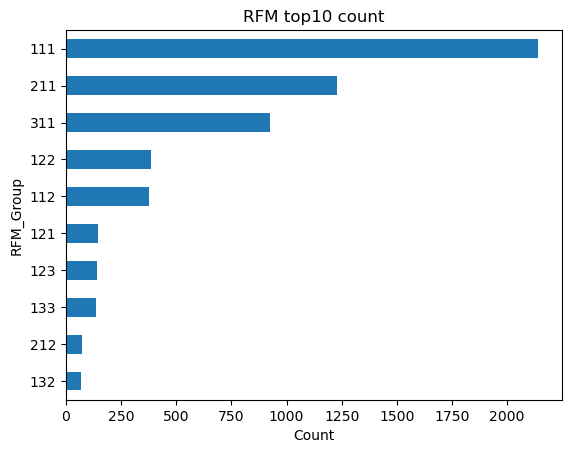

In [43]:
# top10 count
count = group_summary['Customer ID']
count_top10 = count.sort_values(ascending=False).head(10)
count_top10.sort_values(ascending=True).plot.barh()
plt.title('RFM top10 count')
plt.xlabel('Count')
plt.show()

<AxesSubplot:>

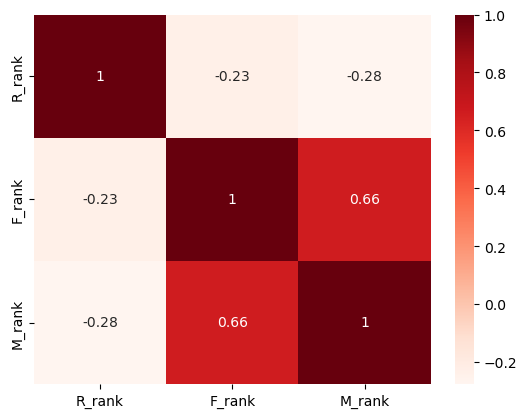

In [44]:
import seaborn as sns
corr_matrix = rfm[['R_rank', 'F_rank', 'M_rank']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Reds')

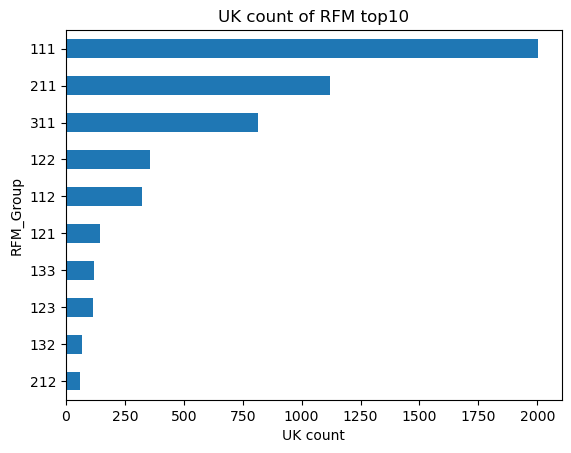

In [68]:
rfm_country = rfm.groupby(['RFM_Group', 'Country']).size().unstack()
top10_rfm = count.sort_values(ascending=False).index[:10]
rfm_country_top10 = rfm_country.loc[top10_rfm]
rfm_uk = rfm_country_top10['United Kingdom']
rfm_uk.sort_values(ascending=True).plot.barh()
plt.title('UK count of RFM top10')
plt.xlabel('UK count')
plt.show()